<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Bayesian-Personalized-Ranking" data-toc-modified-id="Bayesian-Personalized-Ranking-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bayesian Personalized Ranking</a></span><ul class="toc-item"><li><span><a href="#Formulation" data-toc-modified-id="Formulation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Formulation</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Optimization</a></span></li></ul></li><li><span><a href="#Import-the-dataset" data-toc-modified-id="Import-the-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Import the dataset</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Implementation</a></span><ul class="toc-item"><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Item-Recommendations" data-toc-modified-id="Item-Recommendations-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Item Recommendations</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Bayesian Personalized Ranking

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [1]:
import sys
import numpy as np
import pandas as pd
from math import ceil
from tqdm import trange
from subprocess import call
from itertools import islice
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, dok_matrix

# Bayesian Personalized Ranking
<hr style = "border:2px solid black" ></hr>

Recall that when doing matrix factorization for implicit feedback data (users' clicks, view times), we start with a user-item matrix, $R$ where nonzero elements of the matrix are the users' interaction with the items. And what matrix factorization does is it decomposes a large matrix into products of matrices, namely, $R=U×V$.

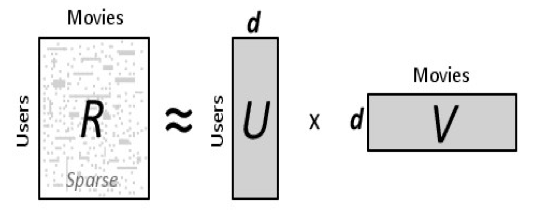

Matrix factorization assumes that:

- Each user can be described by $d$ features. For example, feature 1 might be a referring to how much each user likes disney movies.
- Each item, movie in this case, can be described by an analagous set of $d$ features. To correspond to the above example, feature 1 for the movie might be a number that says how close the movie is to a disney movie.

With that notion in mind, we can denote our $d$ feature user into math by letting a user $u$ take the form of a $1 \times d$-dimensional vector $\textbf{x}_{u}$. Similarly, an item *i* can be represented by a $1 \times d$-dimensional vector $\textbf{y}_{i}$. And we would predict the interactions that the user $u$ will have for item $i$ is by doing a dot product of the two vectors

$$
\begin{align}
\hat r_{ui} &= \textbf{x}_{u} \textbf{y}_{i}^{T} = \sum\limits_{d} x_{ud}y_{di}
\end{align}
$$

Where $\hat r_{ui}$ represents our prediction for the true interactions $r_{ui}$. Next, we will choose a objective function to minimize the square of the difference between all interactions in our dataset ($S$) and our predictions. This produces a objective function of the form:

$$
\begin{align}
L &= \sum\limits_{u,i \in S}( r_{ui} - \textbf{x}_{u} \textbf{y}_{i}^{T} )^{2}
\end{align}
$$

There are cases where we do not wish to optimise for the smalleste difference between the true interaction and the predicted interaction, but instead is the ranking of the items. Meaning given a user, what is the top-N most likely item that the user prefers. And this is what **Bayesian Personalized Ranking (BPR)** tries to accomplish. The idea is centered around sampling positive (items user has interacted with) and negative (items user hasn't interacted with) items and running pairwise comparisons.

## Formulation

Suppose $U$ is the set of all users and $I$ is the set of all items, our goal is to provide user $u$ with a personalized ranking, denoted by $>_u$. As mentioned in the last section, the usual approach for item recommendation algorithm is to predict a personalized score $\hat r_{ui}$ for an item that reflects the user's preference for that item. Then the items are ranked by sorting them according to that score and the top-N is recommended to the user. 

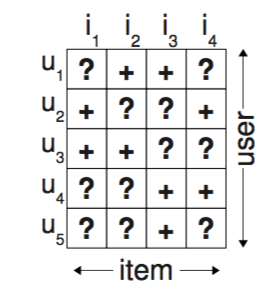

Here we'll use a different approach by using item pairs as training data and optimize for correctly ranking item pairs. From $S$, the whole dataset we try to reconstruct for each user parts of $>_u$. If the user has interacted with item $i$, i.e. $(u,i) \in S$, then we assume that the user prefers this item over all other non-observed items. E.g. in the figure below user $u_1$ has interacted with item $i_2$ but not item $i_1$, so we assume that this user prefers item $i_2$ over $i_1$: $i_2 >_u i_1$. We will denote this generally as $i >_u j$, where the $i$ stands for the positive item and $j$ is for the negative item. For items that the user have both interacted with, we cannot infer any preference. The same is true for two items that a user has not interacted yet (e.g. item $i_1$ and $i_4$ for user $u_1$).



Given these information, we can now get to the Bayesian part of this method. Let $\Theta$ be the parameter of the model that determines the personalized ranking. BPR's goal is to maximize the posterior probability:

$$
\begin{align}
p(\Theta | i >_u j ) \propto p( i >_u j |\Theta) p(\Theta)
\end{align}
$$

$p( i >_u j |\Theta)$ is the likelihood function, it captures the individual probability that a user really prefers item $i$ over item $j$. We compute this probability with the form:

$$
\begin{align}
p( i >_u j |\Theta) = \sigma \big(\hat r_{uij}(\Theta) \big)
\end{align}
$$

Where: $\sigma$ is the good old logistic sigmoid:

$$
\begin{align}
\sigma(x) = \frac{1}{1 + e^{-x}}
\end{align}
$$

And $r_{uij}(\Theta)$ captures the relationship between user $u$, item $i$ and item $j$, which can be further decomposed into:

$$
\begin{align}
\hat r_{uij} = \hat r_{ui} - \hat r_{uj}
\end{align}
$$

For convenience we skipped the argument $\Theta$ from $\hat r_{uij}$. The formula above is basically saying what is the difference between the predicted interaction between the positive item $i$ and the negative item $j$. Now because of this generic framework, we can apply any standard collaborative filtering (such as the matrix factorization) techniques that can predict the interaction between user and item. Keep in mind that although it may seem like we're using the same models as in other work, here we're optimizing against another criterion as we do not try to predict a single predictor $\hat r_{ui}$ but instead tries to classify the difference of two predictions $\hat r_{ui} - \hat r_{uj}$. For those that interested in diving deeper, there's a section in the original paper that showed that the BPR optimization criteria is actually optimizing AUC (Area Under the ROC curve).

So far, we have only discussed the likelihood function. In order to complete the Bayesian modeling approach of the personalized ranking task, we introduce a general prior density $p(\Theta)$ which is a normal distribution with zero mean and variance-covariance matrix $\Sigma (\Theta)$, to reduce the number of unknown hyperparameters, we set: $\Sigma (\Theta) = \lambda_{\Theta} I$

To sum it all up, the full form of the maximum posterior probability optimization (called BPR-Opt in the paper) can be specified as:

$$
\begin{align}
BPR-Opt &= \prod_{u, i, j} p( i >_u j |\Theta) p(\Theta) \\
&= ln \big( \prod_{u, i, j} p( i >_u j |\Theta) p(\Theta) \big) \\
&= \sum_{u, i, j} ln  \sigma \big(\hat r_{ui} - \hat r_{uj} \big) + ln p(\Theta) \\
&= \sum_{u, i, j} ln  \sigma \big(\hat r_{ui} - \hat r_{uj} \big) - \lambda_{\Theta} \left\Vert \Theta \right\Vert ^{2} \\
&= \sum_{u, i, j} ln  \sigma \big(\hat r_{ui} - \hat r_{uj} \big) - \frac{\lambda_{\Theta}}{2} \left\Vert x_u \right\Vert ^{2} - \frac{\lambda_{\Theta}}{2} \left\Vert y_i \right\Vert ^{2} - \frac{\lambda_{\Theta}}{2} \left\Vert y_j \right\Vert ^{2} \\
&= \sum_{u, i, j} ln  \sigma \big( x_u y_i^T - x_u y_j^T \big) - \frac{\lambda_{\Theta}}{2} \left\Vert x_u \right\Vert ^{2} - \frac{\lambda_{\Theta}}{2} \left\Vert y_i \right\Vert ^{2} - \frac{\lambda_{\Theta}}{2} \left\Vert y_j \right\Vert ^{2} \\
&= \sum_{u, i, j} ln  \frac{1}{1 + e^{-(x_u y_i^T - x_u y_j^T) }} - \frac{\lambda_{\Theta}}{2} \left\Vert x_u \right\Vert ^{2} - \frac{\lambda_{\Theta}}{2} \left\Vert y_i \right\Vert ^{2} - \frac{\lambda_{\Theta}}{2} \left\Vert y_j \right\Vert ^{2}
\end{align}
$$

Where:

- We first take the natural log (it's a monotonic transformation, meaning taking the log does not affect the optimization process) to make the product a sum to make life easier on us
- As for the $p(\Theta)$ part, recall that because for each parameter we assume that it's a normal distribution with mean zero ($\mu = 0$), and unit variance ($\Sigma = I$, we ignore the $\lambda_{\Theta}$ for now), the formula for it is:

$$
\begin{align}
N(x \mid \mu, \Sigma) 
&= \frac{1}{(2\pi)^{d/2}\sqrt{|\Sigma|}} exp(-\frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)) \\
&= \frac{1}{(2\pi)^{d/2}} exp(-\frac{1}{2}\Theta^{T}\Theta)
\end{align}
$$

In the formula above, the only thing that depends on $\Theta$ is the $exp(-\frac{1}{2}\Theta^{T}\Theta)$ part on the right, the rest is just a multiplicative constant that we don't need to worry about, thus if we take the natural log of that formula, then the exponential goes away and our $p(\Theta)$ can be written as $- \frac{1}{2} \left\Vert \Theta \right\Vert ^{2}$, and we simply multiply the $\lambda_{\Theta}$ back, which can be seen as the model specific regularization parameter.

Last but not least, in machine learning it's probably more common to try and minimize things, thus we simply flip all the signs of the maximization formula above, leaving us with:

$$
\begin{align}
argmin_{x_u, y_i, y_j} \sum_{u, i, j} -ln \frac{1}{1 + e^{-(x_u y_i^T - x_u y_j^T) }} + \frac{\lambda_{\Theta}}{2} \left\Vert x_u \right\Vert ^{2} + \frac{\lambda_{\Theta}}{2} \left\Vert y_i \right\Vert ^{2} + \frac{\lambda_{\Theta}}{2} \left\Vert y_j \right\Vert ^{2}
\end{align}
$$

## Optimization

In the last section, we have derived an optimization criterion for personalized ranking. As the criterion is differentiable, gradient descent based algorithms are an obvious choice for maximization. But standard gradient descent is probably not the right choice for our problem given the size of all the possible combinations of the triplet $(u, i, j)$. To solve for this issue we use a stochastic gradient descent algorithm that chooses the triplets randomly (uniformly distributed).

To solve for the function using gradient descent, we derive the gradient for the three parameters $x_u$, $y_i$, $y_j$ separately. Just a minor hint when deriving the gradient, remember that the first part of the formula requires the chain rule:

$$
\begin{align}
\dfrac{\partial}{\partial x} ln \sigma(x) 
&= \dfrac{1}{\sigma(x)} \dfrac{\partial}{\partial x} \sigma(x) \\
&= \left( 1 + e^{-x} \right) \dfrac{\partial}{\partial x} \sigma(x) \\
&= \left( 1 + e^{-x} \right) \dfrac{\partial}{\partial x} \left[ \dfrac{1}{1 + e^{-x}} \right] \\
&= \left( 1 + e^{-x} \right) \dfrac{\partial}{\partial x} \left( 1 + \mathrm{e}^{-x} \right)^{-1} \\
&= \left( 1 + e^{-x} \right) \cdot -(1 + e^{-x})^{-2}(-e^{-x}) \\
&= \left( 1 + e^{-x} \right) \dfrac{e^{-x}}{\left(1 + e^{-x}\right)^2} \\
&= \dfrac{e^{-x}}{1 + e^{-x}} \\
&= \dfrac{1}{1 + e^x}
\end{align}
$$

---

$$
\begin{align}
\dfrac{\partial}{\partial x_u}
&= \dfrac{1}{1 + e^{(x_u y_i^T - x_u y_j^T)}} \cdot (y_j - y_i) + \lambda x_u
\end{align}
$$

$$
\begin{align}
\dfrac{\partial}{\partial y_i}
&= \dfrac{1}{1 + e^{(x_u y_i^T - x_u y_j^T)}} \cdot -x_u + \lambda y_i
\end{align}
$$

$$
\begin{align}
\dfrac{\partial}{\partial y_j}
&= \dfrac{1}{1 + e^{(x_u y_i^T - x_u y_j^T)}} \cdot x_u + \lambda y_j
\end{align}
$$

After deriving the gradient the update for each parameter using vanilla gradient descent is:

$$
\begin{align}
\Theta & \Leftarrow \Theta - \alpha \dfrac{\partial}{\partial \Theta}
\end{align}
$$

Where $\alpha$ is the learning rate.

# Import the dataset
<hr style = "border:2px solid black" ></hr>

We will again use the movielens data as an example.

In [3]:
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])

# we will not be using the timestamp column
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(file_path, sep='\t', names=names)
print('data dimension: \n', df.shape)
df.head()

data dimension: 
 (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Implementation
<hr style = "border:2px solid black" ></hr>

Because BPR assumes binary implicit feedback (meaing there's only positive and negative items), here we'll assume that an item is positive only if he/she gave the item a ratings above 3 (feel free to experiment and change the threshold). The next few code chunks, creates the sparse interaction matrix and split into train and test set.

In [4]:
def create_matrix(data, users_col, items_col, ratings_col, threshold=None):
    """
    creates the sparse user-item interaction matrix,
    if the data is not in the format where the interaction only
    contains the positive items (indicated by 1), then use the 
    threshold parameter to determine which items are considered positive

    Parameters
    ----------
    data : DataFrame
        implicit rating data

    users_col : str
        user column name

    items_col : str
        item column name

    ratings_col : str
        implicit rating column name

    threshold : int, default None
        threshold to determine whether the user-item pair is 
        a positive feedback

    Returns
    -------
    ratings : scipy sparse csr_matrix, shape [n_users, n_items]
        user/item ratings matrix

    data : DataFrame
        implict rating data that retains only the positive feedback
        (if specified to do so)
    """
    if threshold is not None:
        data = data[data[ratings_col] >= threshold]
        data[ratings_col] = 1

    for col in (items_col, users_col, ratings_col):
        data[col] = data[col].astype('category')

    ratings = csr_matrix((data[ratings_col],
                          (data[users_col].cat.codes, data[items_col].cat.codes)))
    ratings.eliminate_zeros()
    return ratings, data

In [5]:
items_col = 'item_id'
users_col = 'user_id'
ratings_col = 'rating'
threshold = 3
X, df = create_matrix(df, users_col, items_col, ratings_col, threshold)
X

<943x1574 sparse matrix of type '<class 'numpy.int64'>'
	with 82520 stored elements in Compressed Sparse Row format>

In [6]:
def create_train_test(ratings, test_size=0.2, seed=1234):
    """
    split the user-item interactions matrix into train and test set
    by removing some of the interactions from every user and pretend
    that we never seen them

    Parameters
    ----------
    ratings : scipy sparse csr_matrix, shape [n_users, n_items]
        The user-item interactions matrix

    test_size : float between 0.0 and 1.0, default 0.2
        Proportion of the user-item interactions for each user
        in the dataset to move to the test set; e.g. if set to 0.2
        and a user has 10 interactions, then 2 will be moved to the
        test set

    seed : int, default 1234
        Seed for reproducible random splitting the 
        data into train/test set

    Returns
    ------- 
    train : scipy sparse csr_matrix, shape [n_users, n_items]
        Training set

    test : scipy sparse csr_matrix, shape [n_users, n_items]
        Test set
    """
    assert test_size < 1.0 and test_size > 0.0

    # Dictionary Of Keys based sparse matrix is more efficient
    # for constructing sparse matrices incrementally compared with csr_matrix
    train = ratings.copy().todok()
    test = dok_matrix(train.shape)

    # for all the users assign randomly chosen interactions
    # to the test and assign those interactions to zero in the training;
    # when computing the interactions to go into the test set,
    # remember to round up the numbers (e.g. a user has 4 ratings, if the
    # test_size is 0.2, then 0.8 ratings will go to test, thus we need to
    # round up to ensure the test set gets at least 1 rating)
    rstate = np.random.RandomState(seed)
    for u in range(ratings.shape[0]):
        split_index = ratings[u].indices
        n_splits = ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size=n_splits, replace=False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0

    train, test = train.tocsr(), test.tocsr()
    return train, test

In [7]:
X_train, X_test = create_train_test(X, test_size=0.2, seed=1234)
X_train

<943x1574 sparse matrix of type '<class 'numpy.int64'>'
	with 65641 stored elements in Compressed Sparse Row format>

The following section provides a implementation of the algorithm from scratch.

In [8]:
class BPR:
    """
    Bayesian Personalized Ranking (BPR) for implicit feedback data

    Parameters
    ----------
    learning_rate : float, default 0.01
        learning rate for gradient descent

    n_factors : int, default 20
        Number/dimension of user and item latent factors

    n_iters : int, default 15
        Number of iterations to train the algorithm

    batch_size : int, default 1000
        batch size for batch gradient descent, the original paper
        uses stochastic gradient descent (i.e., batch size of 1),
        but this can make the training unstable (very sensitive to
        learning rate)

    reg : int, default 0.01
        Regularization term for the user and item latent factors

    seed : int, default 1234
        Seed for the randomly initialized user, item latent factors

    verbose : bool, default True
        Whether to print progress bar while training

    Attributes
    ----------
    user_factors : 2d ndarray, shape [n_users, n_factors]
        User latent factors learnt

    item_factors : 2d ndarray, shape [n_items, n_factors]
        Item latent factors learnt

    References
    ----------
    S. Rendle, C. Freudenthaler, Z. Gantner, L. Schmidt-Thieme 
    Bayesian Personalized Ranking from Implicit Feedback
    - https://arxiv.org/abs/1205.2618
    """

    def __init__(self, learning_rate=0.01, n_factors=15, n_iters=10,
                 batch_size=1000, reg=0.01, seed=1234, verbose=True):
        self.reg = reg
        self.seed = seed
        self.verbose = verbose
        self.n_iters = n_iters
        self.n_factors = n_factors
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        # to avoid re-computation at predict
        self._prediction = None

    def fit(self, ratings):
        """
        Parameters
        ----------
        ratings : scipy sparse csr_matrix, shape [n_users, n_items]
            sparse matrix of user-item interactions
        """
        indptr = ratings.indptr
        indices = ratings.indices
        n_users, n_items = ratings.shape

        # ensure batch size makes sense, since the algorithm involves
        # for each step randomly sample a user, thus the batch size
        # should be smaller than the total number of users or else
        # we would be sampling the user with replacement
        batch_size = self.batch_size
        if n_users < batch_size:
            batch_size = n_users
            sys.stderr.write('WARNING: Batch size is greater than number of users,'
                             'switching to a batch size of {}\n'.format(n_users))

        batch_iters = n_users // batch_size

        # initialize random weights
        rstate = np.random.RandomState(self.seed)
        self.user_factors = rstate.normal(size=(n_users, self.n_factors))
        self.item_factors = rstate.normal(size=(n_items, self.n_factors))

        # progress bar for training iteration if verbose is turned on
        loop = range(self.n_iters)
        if self.verbose:
            loop = trange(self.n_iters, desc=self.__class__.__name__)

        for _ in loop:
            for _ in range(batch_iters):
                sampled = self._sample(n_users, n_items, indices, indptr)
                sampled_users, sampled_pos_items, sampled_neg_items = sampled
                self._update(sampled_users, sampled_pos_items,
                             sampled_neg_items)

        return self

    def _sample(self, n_users, n_items, indices, indptr):
        """sample batches of random triplets u, i, j"""
        sampled_pos_items = np.zeros(self.batch_size, dtype=np.int)
        sampled_neg_items = np.zeros(self.batch_size, dtype=np.int)
        sampled_users = np.random.choice(
            n_users, size=self.batch_size, replace=False)

        for idx, user in enumerate(sampled_users):
            pos_items = indices[indptr[user]:indptr[user + 1]]
            pos_item = np.random.choice(pos_items)
            neg_item = np.random.choice(n_items)
            while neg_item in pos_items:
                neg_item = np.random.choice(n_items)

            sampled_pos_items[idx] = pos_item
            sampled_neg_items[idx] = neg_item

        return sampled_users, sampled_pos_items, sampled_neg_items

    def _update(self, u, i, j):
        """
        update according to the bootstrapped user u, 
        positive item i and negative item j
        """
        user_u = self.user_factors[u]
        item_i = self.item_factors[i]
        item_j = self.item_factors[j]

        # decompose the estimator, compute the difference between
        # the score of the positive items and negative items; a
        # naive implementation might look like the following:
        # r_ui = np.diag(user_u.dot(item_i.T))
        # r_uj = np.diag(user_u.dot(item_j.T))
        # r_uij = r_ui - r_uj

        # however, we can do better, so
        # for batch dot product, instead of doing the dot product
        # then only extract the diagonal element (which is the value
        # of that current batch), we perform a hadamard product,
        # i.e. matrix element-wise product then do a sum along the column will
        # be more efficient since it's less operations
        # http://people.revoledu.com/kardi/tutorial/LinearAlgebra/HadamardProduct.html
        # r_ui = np.sum(user_u * item_i, axis = 1)
        #
        # then we can achieve another speedup by doing the difference
        # on the positive and negative item up front instead of computing
        # r_ui and r_uj separately, these two idea will speed up the operations
        # from 1:14 down to 0.36
        r_uij = np.sum(user_u * (item_i - item_j), axis=1)
        sigmoid = np.exp(-r_uij) / (1.0 + np.exp(-r_uij))

        # repeat the 1 dimension sigmoid n_factors times so
        # the dimension will match when doing the update
        sigmoid_tiled = np.tile(sigmoid, (self.n_factors, 1)).T

        # update using gradient descent
        grad_u = sigmoid_tiled * (item_j - item_i) + self.reg * user_u
        grad_i = sigmoid_tiled * -user_u + self.reg * item_i
        grad_j = sigmoid_tiled * user_u + self.reg * item_j
        self.user_factors[u] -= self.learning_rate * grad_u
        self.item_factors[i] -= self.learning_rate * grad_i
        self.item_factors[j] -= self.learning_rate * grad_j
        return self

    def predict(self):
        """
        Obtain the predicted ratings for every users and items
        by doing a dot product of the learnt user and item vectors.
        The result will be cached to avoid re-computing it every time
        we call predict, thus there will only be an overhead the first
        time we call it. Note, ideally you probably don't need to compute
        this as it returns a dense matrix and may take up huge amounts of
        memory for large datasets
        """
        if self._prediction is None:
            self._prediction = self.user_factors.dot(self.item_factors.T)

        return self._prediction

    def _predict_user(self, user):
        """
        returns the predicted ratings for the specified user,
        this is mainly used in computing evaluation metric
        """
        user_pred = self.user_factors[user].dot(self.item_factors.T)
        return user_pred

    def recommend(self, ratings, N=5):
        """
        Returns the top N ranked items for given user id,
        excluding the ones that the user already liked

        Parameters
        ----------
        ratings : scipy sparse csr_matrix, shape [n_users, n_items]
            sparse matrix of user-item interactions 

        N : int, default 5
            top-N similar items' N

        Returns
        -------
        recommendation : 2d ndarray, shape [number of users, N]
            each row is the top-N ranked item for each query user
        """
        n_users = ratings.shape[0]
        recommendation = np.zeros((n_users, N), dtype=np.uint32)
        for user in range(n_users):
            top_n = self._recommend_user(ratings, user, N)
            recommendation[user] = top_n

        return recommendation

    def _recommend_user(self, ratings, user, N):
        """the top-N ranked items for a given user"""
        scores = self._predict_user(user)

        # compute the top N items, removing the items that the user already liked
        # from the result and ensure that we don't get out of bounds error when
        # we ask for more recommendations than that are available
        liked = set(ratings[user].indices)
        count = N + len(liked)
        if count < scores.shape[0]:

            # when trying to obtain the top-N indices from the score,
            # using argpartition to retrieve the top-N indices in
            # unsorted order and then sort them will be faster than doing
            # straight up argort on the entire score
            # http://stackoverflow.com/questions/42184499/cannot-understand-numpy-argpartition-output
            ids = np.argpartition(scores, -count)[-count:]
            best_ids = np.argsort(scores[ids])[::-1]
            best = ids[best_ids]
        else:
            best = np.argsort(scores)[::-1]

        top_n = list(islice((rec for rec in best if rec not in liked), N))
        return top_n

    def get_similar_items(self, N=5, item_ids=None):
        """
        return the top N similar items for itemid, where
        cosine distance is used as the distance metric

        Parameters
        ----------
        N : int, default 5
            top-N similar items' N

        item_ids : 1d iterator, e.g. list or numpy array, default None
            the item ids that we wish to find the similar items
            of, the default None will compute the similar items
            for all the items

        Returns
        -------
        similar_items : 2d ndarray, shape [number of query item_ids, N]
            each row is the top-N most similar item id for each
            query item id
        """
        # cosine distance is proportional to normalized euclidean distance,
        # thus we normalize the item vectors and use euclidean metric so
        # we can use the more efficient kd-tree for nearest neighbor search;
        # also the item will always to nearest to itself, so we add 1 to
        # get an additional nearest item and remove itself at the end
        normed_factors = normalize(self.item_factors)
        knn = NearestNeighbors(n_neighbors=N + 1, metric='euclidean')
        knn.fit(normed_factors)

        # returns a distance, index tuple,
        # we don't actually need the distance
        if item_ids is not None:
            normed_factors = normed_factors[item_ids]

        _, items = knn.kneighbors(normed_factors)
        similar_items = items[:, 1:].astype(np.uint32)
        return similar_items

In [9]:
# parameters were randomly chosen
bpr_params = {'reg': 0.01,
              'learning_rate': 0.1,
              'n_iters': 160,
              'n_factors': 15,
              'batch_size': 100}

bpr = BPR(**bpr_params)
bpr.fit(X_train)

BPR: 100%|██████████| 160/160 [00:01<00:00, 82.94it/s]


## Evaluation

In recommender systems, we are often interested in how well the method can rank a given set of items. And to do that we'll use AUC (Area Under ROC Curve as our evaluation metric. The best possible value that the AUC evaluation metric can take is 1, and any non-random ranking that makes sense would have an AUC > 0.5. An intuitive explanation of AUC is it specifies the probability that when we draw two examples at random, their predicted pairwise ranking is correct. The following [documentation](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/model_selection/auc/auc.ipynb) has a more detailed discussion on AUC in case you're not familiar with it.

In [10]:
def auc_score(model, ratings):
    """
    computes area under the ROC curve (AUC).
    The full name should probably be mean
    auc score as it is computing the auc
    for every user's prediction and actual
    interaction and taking the average for
    all users
    
    Parameters
    ----------
    model : BPR instance
        Trained BPR model
        
    ratings : scipy sparse csr_matrix, shape [n_users, n_items]
        sparse matrix of user-item interactions
    
    Returns
    -------
    auc : float 0.0 ~ 1.0
    """
    auc = 0.0
    n_users, n_items = ratings.shape
    for user, row in enumerate(ratings):
        y_pred = model._predict_user(user)
        y_true = np.zeros(n_items)
        y_true[row.indices] = 1
        auc += roc_auc_score(y_true, y_pred)

    auc /= n_users
    return auc

In [11]:
print(auc_score(bpr, X_train))
print(auc_score(bpr, X_test))

0.895754675889
0.824883963053


## Item Recommendations

Given the trained model, we can get the most similar items by using the `get_similar_items` method, we can specify the number of most similar items by specifying the `N` argument. And this can be seen as the people who like/buy this also like/buy this functionality, since it's recommending similar items for a given item.

In [12]:
bpr.get_similar_items(N = 5)

array([[  49,  180,  120,   24,  116],
       [ 695, 1184,  844,  213,  464],
       [1519,  816,  225,  116, 1522],
       ..., 
       [ 447,  807,  957,   74, 1016],
       [ 422, 1302,  779, 1086, 1036],
       [ 697,  809, 1459, 1465,  815]], dtype=uint32)

On the other hand, we can also generate a top-N recommended item for each given user, by passing the sparse rating data and `N` to the `recommend` method.

In [13]:
bpr.recommend(X_train, N = 5)

array([[421, 256, 425, 490, 182],
       [806, 317, 123,  14,   8],
       [744, 285, 312, 331, 301],
       ..., 
       [210, 403, 621, 728, 654],
       [293, 741, 403, 180, 744],
       [233,   0, 234, 248, 264]], dtype=uint32)

For these two methods, we can go one step further and look-up the actual item for these indices to see if they make intuitive sense. If we wish to do this, the movielens dataset has a `u.item` file that contains metadata about the movie.

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- [Wiki: Area Under the ROC Curve](http://www.recsyswiki.com/wiki/Area_Under_the_ROC_Curve)
- [StackExchange: Derivative of sigmoid function](http://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x)
- [Blog: What you wanted to know about AUC](http://fastml.com/what-you-wanted-to-know-about-auc/)
- [Blog: Learning to Rank Sketchfab Models with LightFM](http://blog.ethanrosenthal.com/2016/11/07/implicit-mf-part-2/)
- [Blog (Chinese Mandarin): BPR [Bayesian Personalized Ranking]](http://liuzhiqiangruc.iteye.com/blog/2073526)
- [Github: An implementation of Bayesian Personalised Ranking in Theano](https://github.com/bbc/theano-bpr)
- [Paper: S. Rendle, C. Freudenthaler, Z. Gantner, L. Schmidt-Thieme - Bayesian Personalized Ranking from Implicit Feedback](https://arxiv.org/abs/1205.2618)
- [This notebook code](https://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/recsys/4_bpr.ipynb)

</font>
</div>